In [9]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, 
    LeakyReLU, BatchNormalization, Dropout, Dense, GaussianNoise
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
import os

In [10]:
# Đường dẫn tới dữ liệu
color_dir = "/kaggle/input/image-colorization/color"
gray_dir  = "/kaggle/input/image-colorization/gray"

# Lấy danh sách file (sắp xếp theo thứ tự tên file)
color_files = sorted([os.path.join(color_dir, f) for f in os.listdir(color_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
gray_files  = sorted([os.path.join(gray_dir, f) for f in os.listdir(gray_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

In [11]:
def resize_and_normalize_image(image_path, is_gray=False):
    """ Đọc, resize và chuẩn hóa ảnh """
    IMG_SIZE = (128, 128)  # Kích thước ảnh mong muốn

    # Đọc ảnh theo chế độ phù hợp
    flag = cv2.IMREAD_GRAYSCALE if is_gray else cv2.IMREAD_COLOR
    img = cv2.imread(image_path, flag)

    # Kiểm tra nếu ảnh không hợp lệ
    if img is None:
        print(f"Lỗi khi đọc ảnh: {image_path}")
        return None
    
    # Resize ảnh
    img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
    
    # Chuẩn hóa giá trị pixel về khoảng [-1, 1]
    img = img.astype(np.float32) / 127.5 - 1

    # Nếu là ảnh grayscale, thêm chiều kênh (1 kênh)
    if is_gray:
        img = np.expand_dims(img, axis=-1)

    return img

# Load và tiền xử lý dataset
def load_dataset(file_list, is_gray=False):
    """ Hàm load và tiền xử lý tập dữ liệu """
    images = [resize_and_normalize_image(f, is_gray) for f in file_list]
    return np.array([img for img in images if img is not None])  # Lọc bỏ ảnh lỗi

# Tiền xử lý ảnh màu và ảnh xám
color_images = load_dataset(color_files, is_gray=False)
gray_images = load_dataset(gray_files, is_gray=True)

# In kích thước tập dữ liệu
print("Shape of color images:", color_images.shape)  # (N, 128, 128, 3)
print("Shape of gray images:", gray_images.shape)    # (N, 128, 128, 1)


Shape of color images: (12868, 128, 128, 3)
Shape of gray images: (12868, 128, 128, 1)


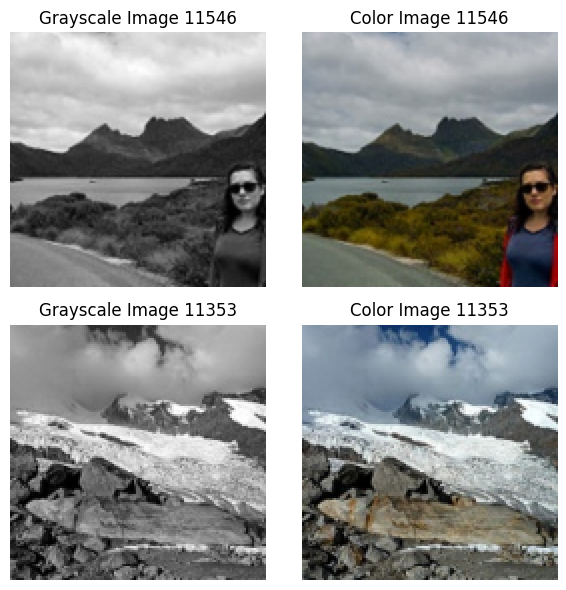

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_images(gray_images, color_images, num_samples=2):
    """ Hiển thị ngẫu nhiên một số ảnh grayscale và ảnh màu với đúng gam màu """
    
    # Chọn ngẫu nhiên `num_samples` index từ tập dữ liệu
    indices = random.sample(range(len(gray_images)), num_samples)

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

    for i, idx in enumerate(indices):
        # Chuyển ảnh grayscale về dạng hiển thị (0 - 255)
        img_gray = (gray_images[idx] + 1) * 127.5
        img_gray = np.clip(img_gray, 0, 255).astype(np.uint8)

        # Chuyển ảnh màu về dạng hiển thị (0 - 255) và đổi thứ tự kênh từ BGR -> RGB
        img_color = (color_images[idx] + 1) * 127.5
        img_color = np.clip(img_color, 0, 255).astype(np.uint8)
        img_color = img_color[..., ::-1]  # Chuyển từ BGR -> RGB

        # Ảnh grayscale
        axes[i, 0].imshow(img_gray.squeeze(), cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Grayscale Image {idx}")

        # Ảnh màu (đã đổi về RGB)
        axes[i, 1].imshow(img_color)
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Color Image {idx}")

    plt.tight_layout()
    plt.show()

show_random_images(gray_images, color_images, num_samples=2)


In [13]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, 
                                     Dropout, Concatenate, Add, Activation, Lambda)
from tensorflow.keras.models import Model

# Hàm ResNet Block giúp giữ thông tin khi training
def resnet_block(x, filters, kernel_size=3):
    res = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    res = BatchNormalization()(res)
    res = LeakyReLU(0.2)(res)
    res = Conv2D(filters, kernel_size, padding='same', activation=None)(res)
    res = BatchNormalization()(res)
    return Add()([x, res])  # Cộng đầu vào với đầu ra giúp giữ đặc trưng

def build_generator():
    inputs = Input(shape=(128, 128, 1))
    
    # Encoder
    e1 = Conv2D(128, (4,4), strides=2, padding='same')(inputs)
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(256, (4,4), strides=2, padding='same')(e1)
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(512, (4,4), strides=2, padding='same')(e2)
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)
    
    e4 = Conv2D(1024, (4,4), strides=2, padding='same')(e3)
    e4 = BatchNormalization()(e4)
    e4 = LeakyReLU(0.2)(e4)
    e4 = Dropout(0.3)(e4)
    
    # Thêm ResNet Blocks để cải thiện khả năng học
    res_block = resnet_block(e4, 1024)

    # Decoder
    d1 = Conv2DTranspose(512, (4,4), strides=2, padding='same', activation=None)(res_block)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.3)(d1)
    d1 = LeakyReLU(0.2)(d1)
    d1 = Concatenate()([d1, e3])
    
    d2 = Conv2DTranspose(256, (4,4), strides=2, padding='same', activation=None)(d1)
    d2 = BatchNormalization()(d2)
    d2 = LeakyReLU(0.2)(d2)
    d2 = Concatenate()([d2, e2])
    
    d3 = Conv2DTranspose(128, (4,4), strides=2, padding='same', activation=None)(d2)
    d3 = BatchNormalization()(d3)
    d3 = LeakyReLU(0.2)(d3)
    d3 = Concatenate()([d3, e1])
    
    d4 = Conv2DTranspose(3, (4,4), strides=2, padding='same', activation='tanh')(d3)
    
    return Model(inputs, d4)

# Tạo generator
generator = build_generator()
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, 64, 128)    │          2,176 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 64, 64, 128)    │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ leaky_re_lu[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 256)    │          1,024 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 32, 32, 256)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ leaky_re_lu_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 512)    │          2,048 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 16, 16, 512)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 8, 8, 1024)     │      8,389,632 │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 8, 8, 1024)     │          4,096 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 8, 8, 1024)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 8, 8, 1024)     │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 8, 8, 1024)     │          4,096 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 8, 8, 1024)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ leaky_re_lu_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 43,554,051 (166.15 MB)

 Trainable params: 43,544,579 (166.11 MB)

 Non-trainable params: 9,472 (37.00 KB)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, LeakyReLU, BatchNormalization, Dropout, 
                                     Flatten, Dense, GaussianNoise)
from tensorflow.keras.models import Model

def build_discriminator():
    inputs = Input(shape=(128, 128, 3))
    x = GaussianNoise(0.1)(inputs)  # Thêm nhiễu Gaussian để tăng tính tổng quát
    
    x = Conv2D(128, (4,4), strides=2, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    
    x = Conv2D(256, (4,4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(512, (4,4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    
    x = Conv2D(1024, (4,4), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.4)(x)
    
    x = Dense(1)(x)  # Không dùng sigmoid để phù hợp với WGAN
    
    return Model(inputs, x)

# Tạo discriminator
discriminator = build_discriminator()
discriminator.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │           6,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 1024)          │       8,389,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 8, 8, 1024)          │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8, 8, 1)             │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,026,305 (42.06 MB)

 Trainable params: 11,022,721 (42.05 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Khởi tạo Generator và Discriminator
generator = build_generator()
discriminator = build_discriminator()

# Biên dịch Discriminator
discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Nếu dùng sigmoid, đổi thành False
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Đóng băng Discriminator khi huấn luyện GAN
discriminator.trainable = True

# Xây dựng GAN
inputs = Input(shape=(128, 128, 1))
generated_image = generator(inputs, training=True)  # Giúp BatchNorm trong Generator hoạt động tốt
validity = discriminator(generated_image)

gan = Model(inputs, validity)

# Biên dịch GAN
gan.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Nếu dùng sigmoid, đổi thành False
            optimizer=Adam(0.0002, 0.5))


In [16]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

def train_gan(gray_images, color_images, epochs=100, batch_size=32):
    # ✅ Chia tập train (80%) và validation (20%)
    X_train, X_val, Y_train, Y_val = train_test_split(gray_images, color_images, test_size=0.2, shuffle=True, random_state=42)

    loss_history = []
    half_batch = batch_size // 2
    n_critic = 3  # Số lần cập nhật D trước khi cập nhật G

    @tf.function
    def train_discriminator_step(real_images, real_colors):
        with tf.GradientTape() as tape:
            fake_images = generator(real_images, training=True)
            real_output = discriminator(real_colors, training=True)
            fake_output = discriminator(fake_images, training=True)

            d_loss = discriminator_loss(real_output, fake_output)

        d_gradients = tape.gradient(d_loss, discriminator.trainable_variables)
        d_optimizer.apply_gradients(zip(d_gradients, discriminator.trainable_variables))
        
        real_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(real_output) > 0.5, tf.float32))
        fake_acc = tf.reduce_mean(tf.cast(tf.nn.sigmoid(fake_output) < 0.5, tf.float32))
        d_acc = (real_acc + fake_acc) / 2
        return d_loss, d_acc

    @tf.function
    def train_generator_step(real_images):
        with tf.GradientTape() as tape:
            fake_images = generator(real_images, training=True)
            fake_output = discriminator(fake_images, training=True)

            g_loss = generator_loss(fake_output)

        g_gradients = tape.gradient(g_loss, generator.trainable_variables)
        g_optimizer.apply_gradients(zip(g_gradients, generator.trainable_variables))
        return g_loss

    for epoch in range(epochs):
        for _ in range(n_critic):  # Cập nhật Discriminator nhiều lần
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            real_images, real_colors = X_train[idx], Y_train[idx]
            d_loss, d_acc = train_discriminator_step(real_images, real_colors)

        # ✅ Cập nhật Generator 1 lần
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]
        g_loss = train_generator_step(real_images)

        loss_history.append((d_loss.numpy(), g_loss.numpy()))
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | D Acc: {d_acc:.2%} | G Loss: {g_loss:.4f}")

        # Lưu model mỗi 50 epochs
        if (epoch + 1) % 50 == 0:
            generator.save("colorizer_gan_unet.h5")
            print("✅ Saved generator model.")

    generator.save("colorizer_gan_final.h5")
    print("✅ Final generator model saved.")

    return generator, loss_history


In [17]:
import tensorflow as tf

# ✅ Cập nhật hàm loss cho Discriminator
def discriminator_loss(real_output, fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # ✅ Sửa from_logits=True
    real_loss = loss_fn(tf.ones_like(real_output), real_output)
    fake_loss = loss_fn(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# ✅ Cập nhật hàm loss cho Generator
def generator_loss(fake_output):
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)  # Không dùng logits
    return loss_fn(tf.ones_like(fake_output), fake_output)

# ✅ Kiểm tra nếu Discriminator không có gradient
def check_gradients(loss, model):
    grads = tf.GradientTape().gradient(loss, model.trainable_variables)
    if any(g is None for g in grads):
        print("⚠️ Cảnh báo: Không có gradient! Kiểm tra lại loss và mô hình.")
    return grads

# ✅ Khai báo lại Optimizer
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)


In [18]:
generator, loss_history = train_gan(gray_images, color_images, epochs=100, batch_size=32)

Epoch 1/100 | D Loss: 2.7603 | D Acc: 49.27% | G Loss: 1.0674
Epoch 2/100 | D Loss: 1.8944 | D Acc: 48.78% | G Loss: 0.8696
Epoch 3/100 | D Loss: 2.0150 | D Acc: 45.75% | G Loss: 0.9427
Epoch 4/100 | D Loss: 1.7119 | D Acc: 49.46% | G Loss: 0.8421
Epoch 5/100 | D Loss: 1.6282 | D Acc: 52.54% | G Loss: 0.9185
Epoch 6/100 | D Loss: 1.7835 | D Acc: 52.83% | G Loss: 0.8939
Epoch 7/100 | D Loss: 1.7156 | D Acc: 50.93% | G Loss: 0.9432
Epoch 8/100 | D Loss: 1.8368 | D Acc: 51.27% | G Loss: 1.7652
Epoch 9/100 | D Loss: 2.0905 | D Acc: 47.36% | G Loss: 1.1316
Epoch 10/100 | D Loss: 1.6284 | D Acc: 53.76% | G Loss: 1.1124
Epoch 11/100 | D Loss: 1.7486 | D Acc: 50.15% | G Loss: 0.8815
Epoch 12/100 | D Loss: 1.9379 | D Acc: 47.41% | G Loss: 1.4608
Epoch 13/100 | D Loss: 1.7652 | D Acc: 51.46% | G Loss: 0.9843
Epoch 14/100 | D Loss: 1.6009 | D Acc: 55.86% | G Loss: 0.9601
Epoch 15/100 | D Loss: 1.7642 | D Acc: 57.67% | G Loss: 1.0765
Epoch 16/100 | D Loss: 1.3845 | D Acc: 62.60% | G Loss: 0.9551
E

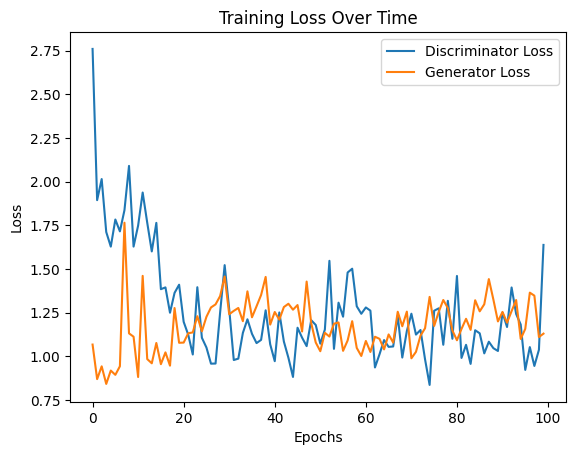

In [19]:
import matplotlib.pyplot as plt

# ✅ Vẽ biểu đồ loss
loss_history = np.array(loss_history)
plt.plot(loss_history[:, 0], label="Discriminator Loss")
plt.plot(loss_history[:, 1], label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss Over Time")
plt.show()

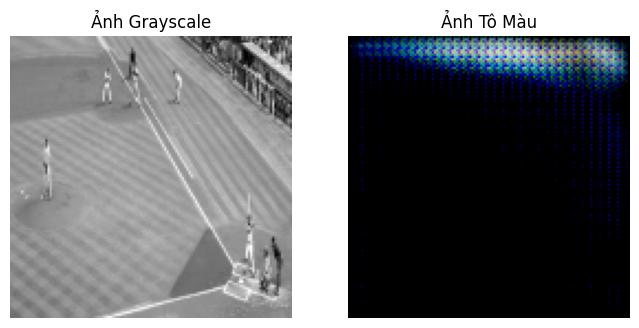

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ✅ Load lại generator đã train
generator = tf.keras.models.load_model("colorizer_gan_final.h5")

def colorize_image(grayscale_image):
    """
    Hàm nhận ảnh grayscale (128x128x1) và sinh ảnh màu (128x128x3)
    """
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Thêm batch dimension (1, 128, 128, 1)
    generated_color = generator(grayscale_image, training=False)  # Sinh ảnh màu
    generated_color = np.clip(generated_color.numpy()[0], 0, 1)  # Đưa về khoảng [0,1]
    return generated_color

# ✅ Load ảnh grayscale test
test_gray_image = cv2.imread("/kaggle/input/image-colorization/gray/gray_00059.png", cv2.IMREAD_GRAYSCALE)
test_gray_image = cv2.resize(test_gray_image, (128, 128)) / 255.0  # Chuẩn hóa về [0,1]
test_gray_image = np.expand_dims(test_gray_image, axis=-1)  # Thêm channel để thành (128,128,1)

# ✅ Sinh ảnh màu
generated_color_image = colorize_image(test_gray_image)

# ✅ Hiển thị kết quả
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(test_gray_image.squeeze(), cmap="gray")
plt.title("Ảnh Grayscale")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(generated_color_image)
plt.title("Ảnh Tô Màu")
plt.axis("off")

plt.show()
